# IHS locus artwork

## Setup

In [255]:
%run locus-artwork-setup.ipynb

In [153]:
def plot_ihs_max_percentiles(pop, window_size=50, window_step=50):
    fig, ax = plt.subplots(facecolor='w', figsize=(9, 3))
    
    # plot each chromosome
    x = list(range(90, 100)) + [99.5, 99.9]
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, ihs_max, _, _, _ = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
        all_vals.append(ihs_max)
        # plot 
        y = [np.percentile(ihs_max, i) for i in x]
        ax.plot(x, y, marker='o', label=chromosome)
        
    # plot all
    ihs_max = np.concatenate(all_vals)
    y = [np.percentile(ihs_max, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
#     ax.set_ylim(bottom=0, top=0.4)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$|IHS|_{max}$')
    ax.set_title(pop_defs[pop]['label'])
    
    plt.show()
    plt.close()
    

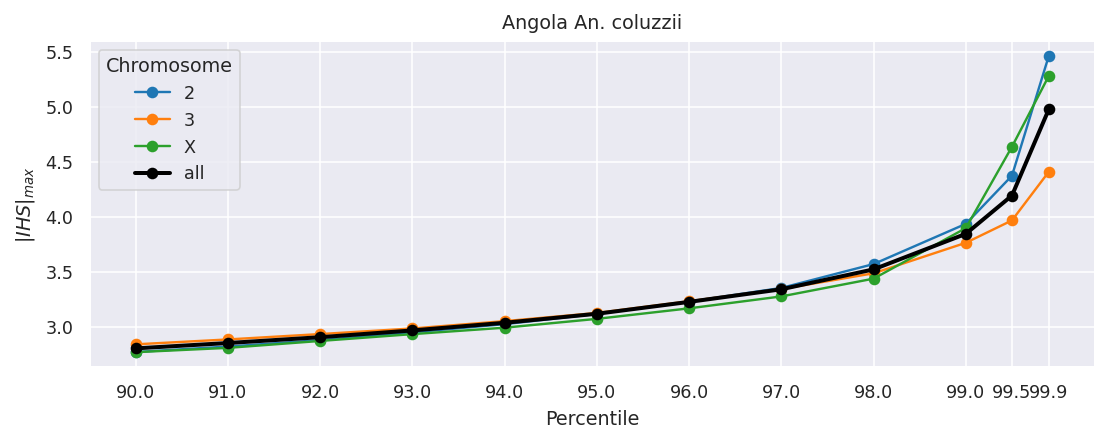

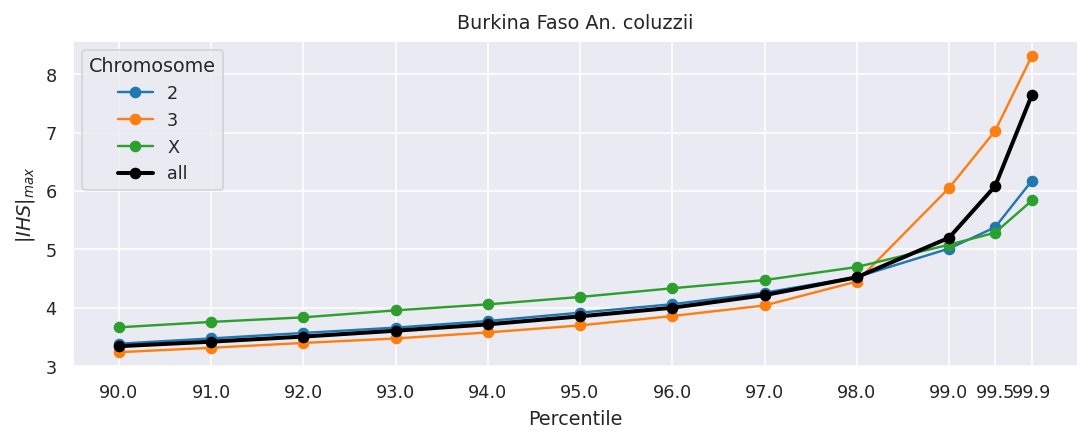

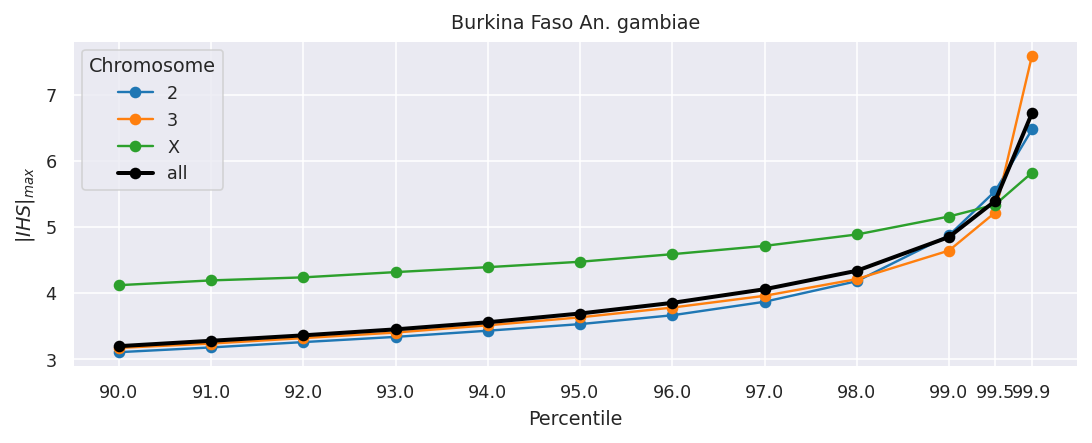

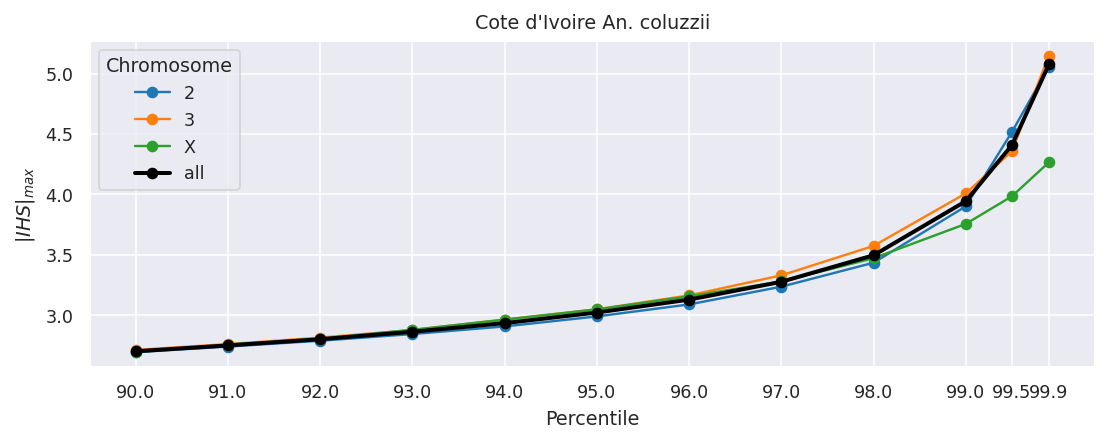

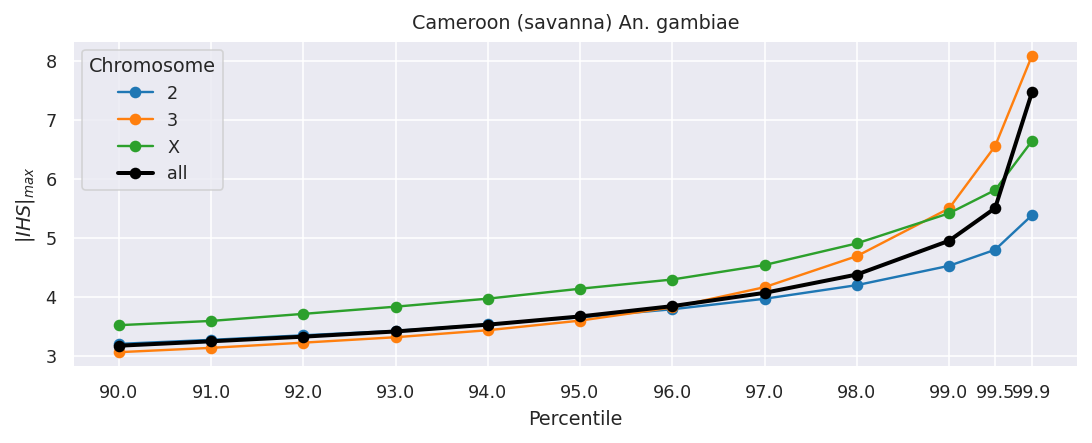

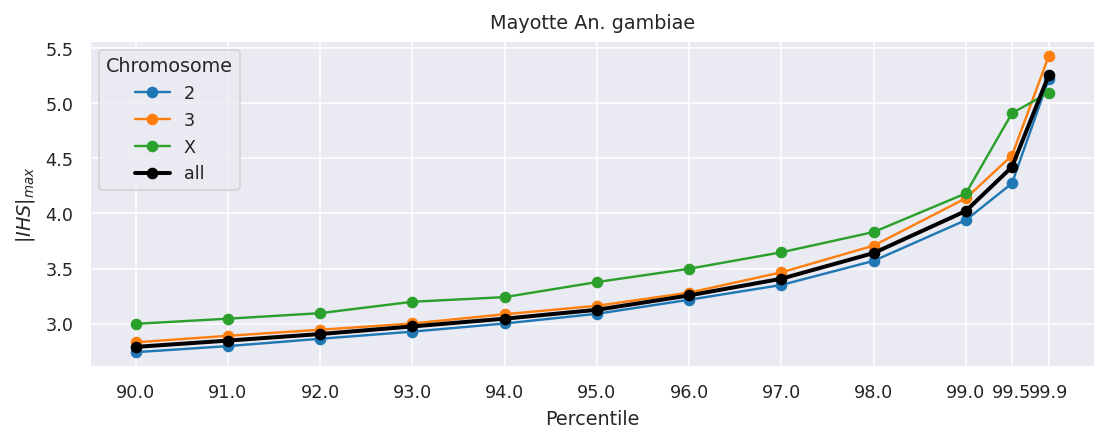

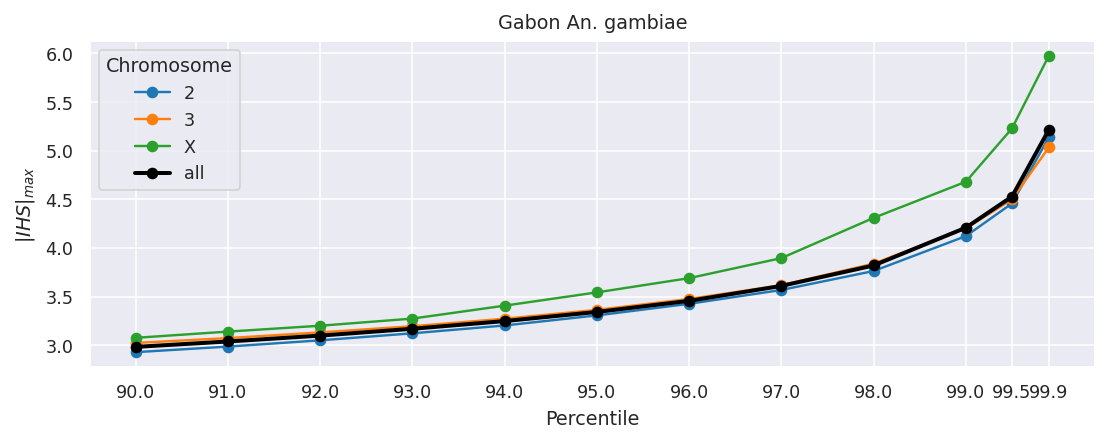

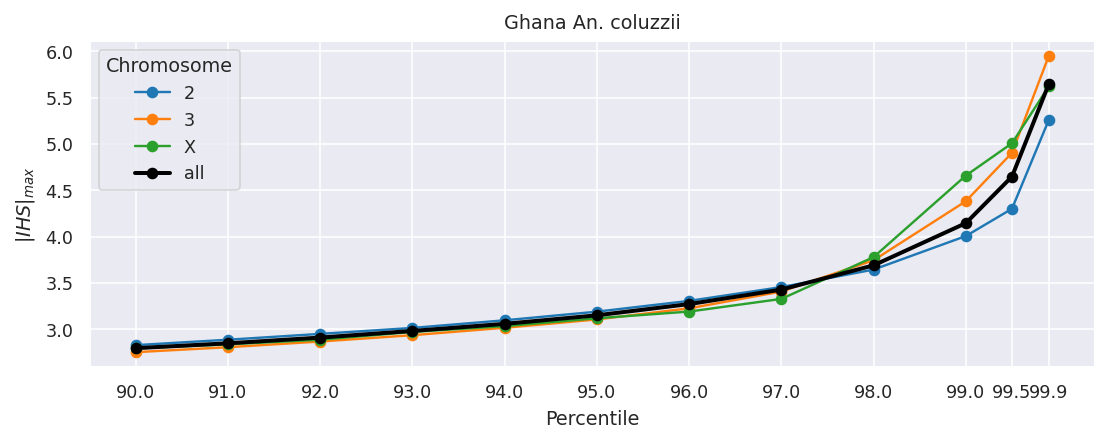

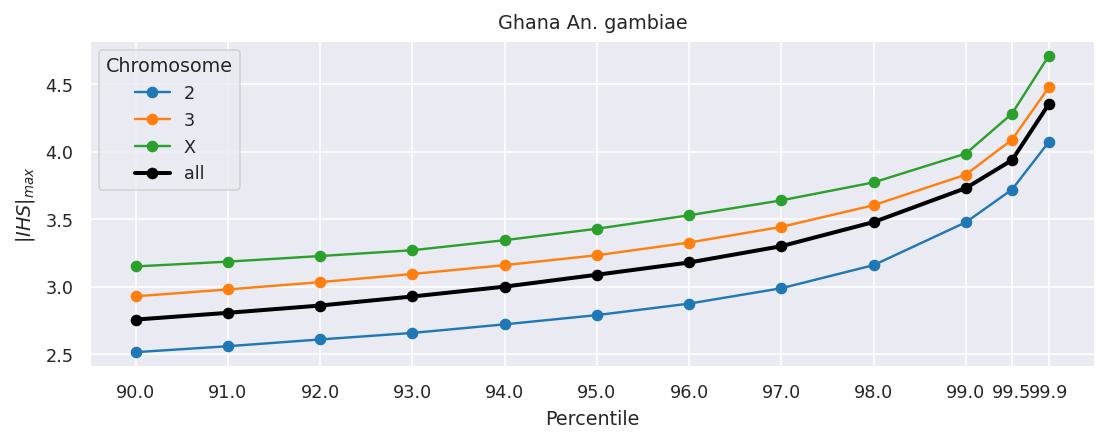

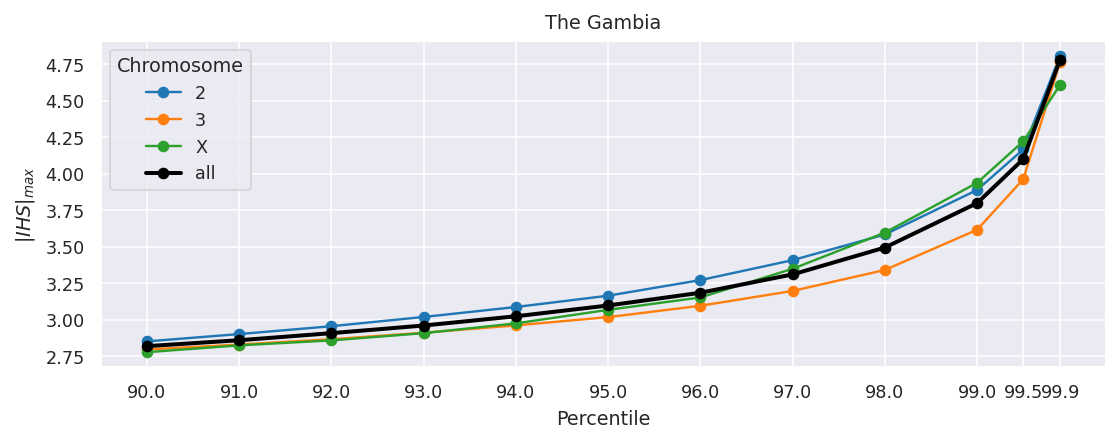

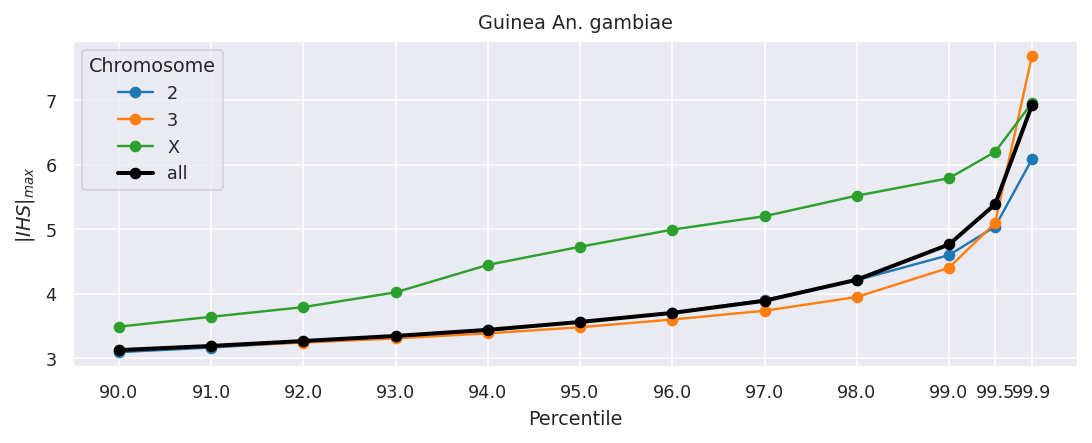

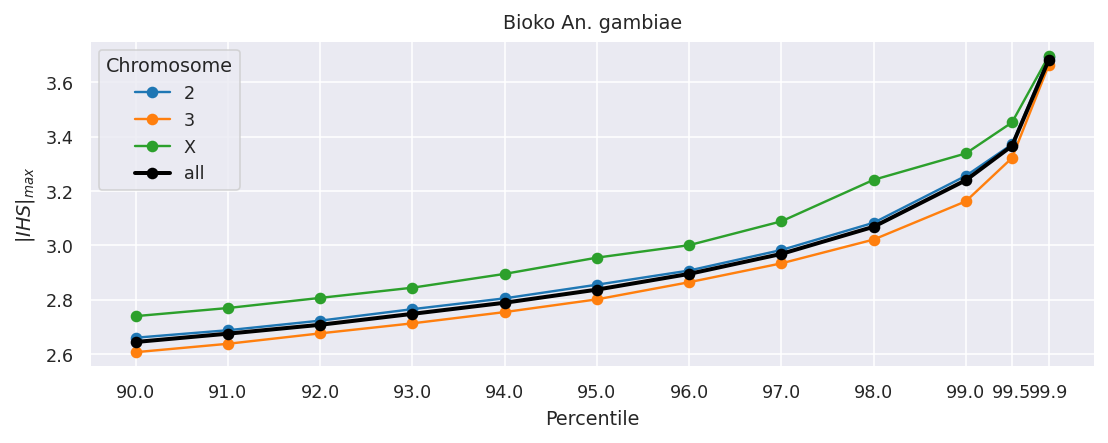

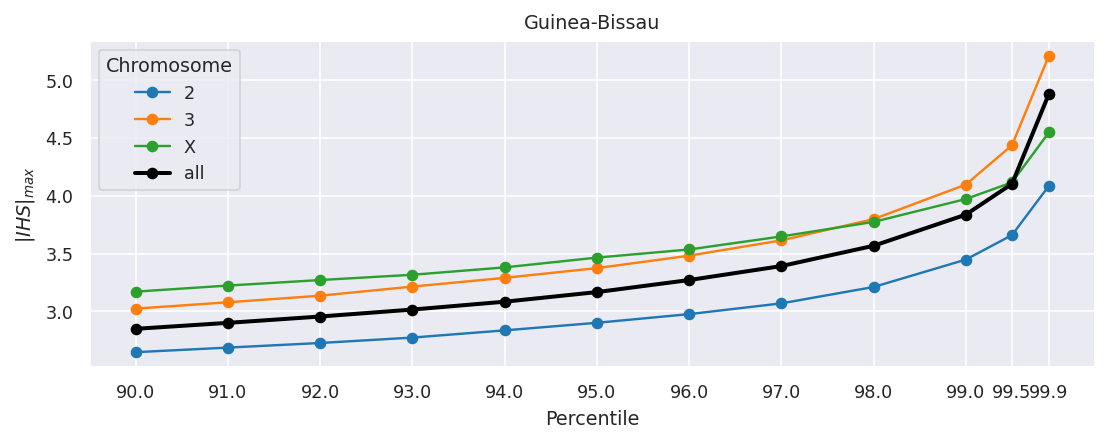

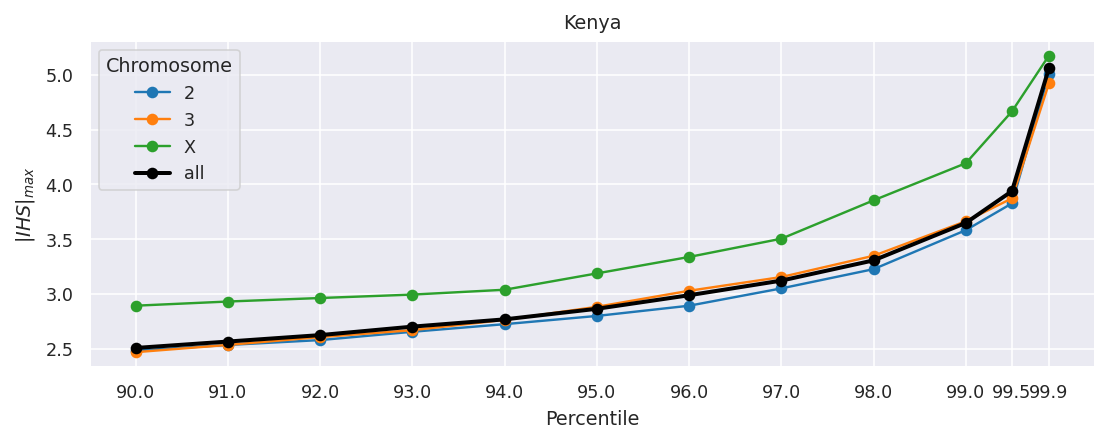

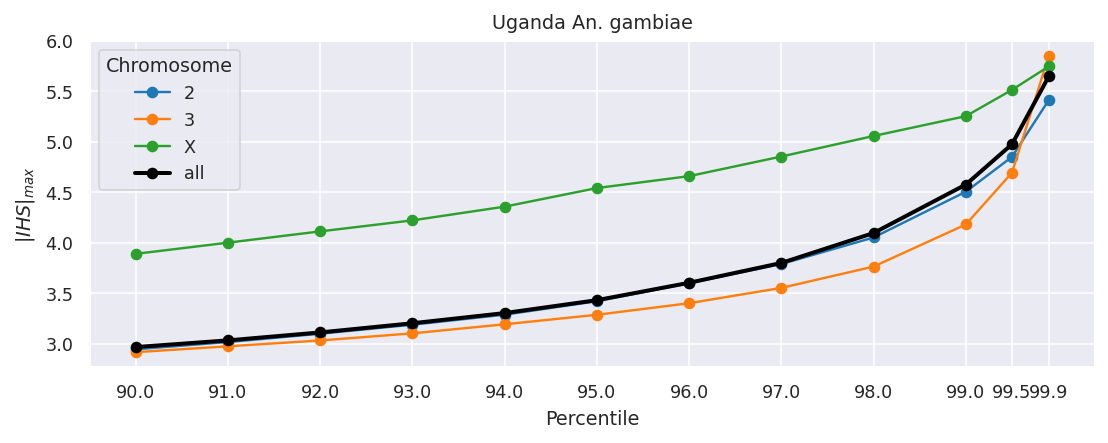

In [154]:
for pop in pop_defs:
    plot_ihs_max_percentiles(pop)

In [202]:
@functools.lru_cache(maxsize=None)
def get_ihs_percentile(pop, q):
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        grp = ihs_root[f'{pop}/{chromosome}']
        ihs_std = np.fabs(grp['ihs_std'][:])
        all_vals.append(ihs_std)
    ihs_std = np.concatenate(all_vals)
    return np.percentile(ihs_std, q)


In [203]:
get_ihs_percentile('ug_gam', 99)

2.963383665221318

In [155]:
@functools.lru_cache(maxsize=None)
def get_ihs_max_percentile(pop, q, window_size, window_step):
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, ihs_max, _, _, _ = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
        all_vals.append(ihs_max)
    ihs_max = np.concatenate(all_vals)
    return np.percentile(ihs_max, q)
    

In [157]:
get_ihs_max_percentile('bf_gam', 99, window_size=50, window_step=50)

4.84588895871614

In [232]:
def plot_ihs_snp(pop, chromosome, center, flank, ax=None, markersize=2, 
                 label=True, ymax=None, genetic_distance=False,
                 percentiles=[99, 99.5, 99.9], 
                 has_peak_n=50, has_peak_dist=.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
    else:
        raise ValueError

    # load gwss data
    grp = ihs_root[f'{pop}/{chromosome}']
    p = grp['pos'][:]
    gp = grp['gpos'][:]
    ihs_std = np.fabs(grp['ihs_std'][:])
    p = p/1e6
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p

    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_ihs_percentile(pop, q)
        qvals.append(v)
        ax.axhline(v, color='k', linestyle='--', lw=.5)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot gwss data
    palette = sns.color_palette()
    ax.plot(x, ihs_std, marker='o', linestyle=' ',
            markersize=markersize, color=palette[3], mfc='none')

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        ymax = max(1.1*max(qvals), 1.1*np.max(ihs_std[loc_xlim]))
    ax.set_ylim(0, ymax)
    ax.set_ylabel('$|IHS|$')
            
    # statistics
    has_peak = False
    try:
        loc_peak_test = allel.SortedIndex(p).locate_range(center-has_peak_dist, center+has_peak_dist)
        has_peak = np.count_nonzero(ihs_std[loc_peak_test] > qvals[-1]) > has_peak_n
    except KeyError:
        pass
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-1, center+1)
        peak_value = np.max(ihs_std[loc_region])
        pos_peak = p[loc_region][np.argmax(ihs_std[loc_region])] - center
        statistics = dict(
            pop=pop,
            ihs_peak=peak_value,
            pos_ihs_peak=pos_peak
        )
    else:
        statistics = dict(
            pop=pop,
            ihs_peak=np.nan,
            pos_ihs_peak=np.nan,
        )
    
    if label:
        pop_label = (
            pop_defs[pop]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        if has_peak:
            annotation = (
                f"{pop_label}\n$"
                f"|IHS|_{{peak}}={peak_value:.1f}$\n"
                f"$pos(|IHS|_{{peak}})={pos_peak*1e3:+.1f}$ kbp"
            )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xytext=(8, -8), 
                    xycoords='axes fraction', textcoords='offset points', 
                    fontsize=8, va='top', ha='left', backgroundcolor='white')
    
    return statistics


In [261]:
def plot_ihs_max(pop, chromosome, center, flank, ax=None, markersize=2, 
                 window_size=50, window_step=50,
                 legend=False, label=True, ymax=None, genetic_distance=False,
                 percentiles=[98], has_peak_n=20,
                 has_peak_dist=.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
    else:
        raise ValueError

    # load gwss data
    p, gp, ihs_max, _, _, _ = load_ihs_gwss(
        pop, chromosome, window_size=window_size, window_step=window_step
    )
    p = p/1e6
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p

    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_ihs_max_percentile(pop, q, window_size=window_size, 
                                   window_step=window_step)
        qvals.append(v)
        ax.axhline(v, color='k', linestyle='--', lw=.5)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot gwss data
    palette = sns.color_palette()
    ax.plot(x, ihs_max, marker='o', linestyle=' ', 
            markersize=markersize, color=palette[3])

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        ymax = max(1.1*max(qvals), 1.1*np.max(ihs_max[loc_xlim]))
    ax.set_ylim(1, ymax)
    ax.set_ylabel('$|IHS|$')
            
    # statistics
    has_peak = False
    try:
        loc_peak_test = allel.SortedIndex(p).locate_range(center-has_peak_dist, center+has_peak_dist)
        has_peak = np.count_nonzero(ihs_max[loc_peak_test] > qvals[-1]) > has_peak_n
    except KeyError:
        pass
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-1, center+1)
        peak_value = np.max(ihs_max[loc_region])
        pos_peak = p[loc_region][np.argmax(ihs_max[loc_region])] - center
        statistics = dict(
            pop=pop,
            ihs_peak=peak_value,
            pos_ihs_peak=pos_peak
        )
    else:
        statistics = dict(
            pop=pop,
            ihs_peak=np.nan,
            pos_ihs_peak=np.nan,
        )
    
    if label:
        pop_label = (
            pop_defs[pop]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        if has_peak:
            annotation = (
                f"{pop_label}\n$"
                f"|IHS|_{{peak}}={peak_value:.1f}$\n"
                f"$pos(|IHS|_{{peak}})={pos_peak*1e3:+.1f}$ kbp"
            )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xytext=(8, -8), 
                    xycoords='axes fraction', textcoords='offset points', 
                    fontsize=8, va='top', ha='left', backgroundcolor='white')
    
    return statistics


{'pop': 'bf_gam', 'ihs_peak': nan, 'pos_ihs_peak': nan}

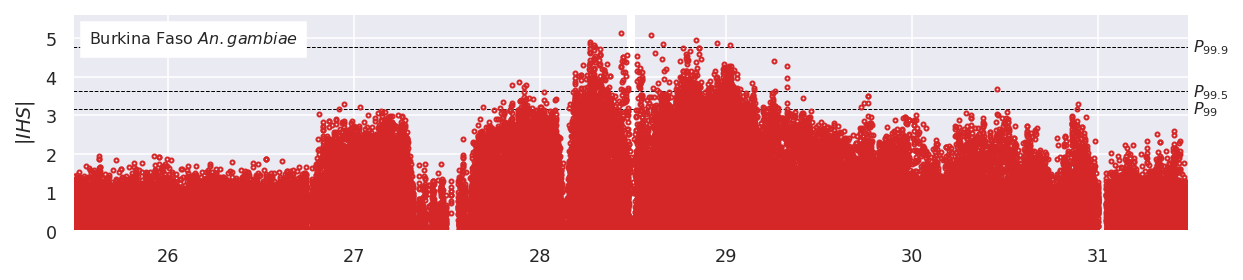

In [262]:
plot_ihs_snp('bf_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3)

{'pop': 'bf_gam', 'ihs_peak': nan, 'pos_ihs_peak': nan}

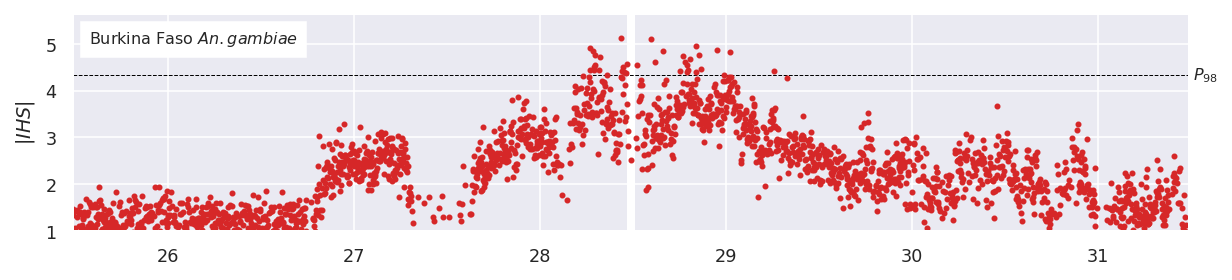

In [263]:
plot_ihs_max('bf_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3)

{'pop': 'gn_gam',
 'ihs_peak': 5.579563993087699,
 'pos_ihs_peak': 0.27740890000000107}

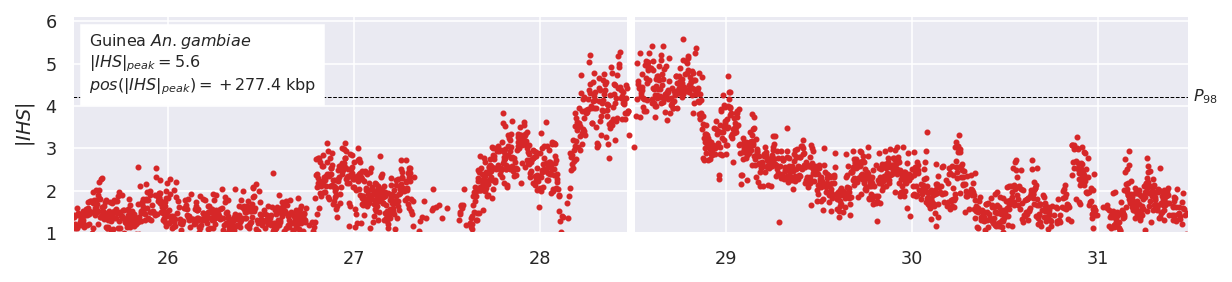

In [264]:
plot_ihs_max('gn_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3)

{'pop': 'bf_col', 'ihs_peak': nan, 'pos_ihs_peak': nan}

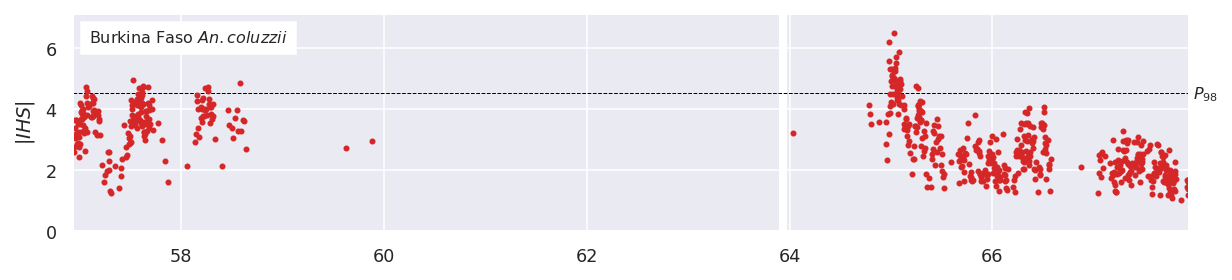

In [251]:
plot_ihs_max('bf_col', vgsc.chromosome, vgsc.chromosome_center/1e6, 
             flank=(7, 4))

{'pop': 'bf_col', 'ihs_peak': nan, 'pos_ihs_peak': nan}

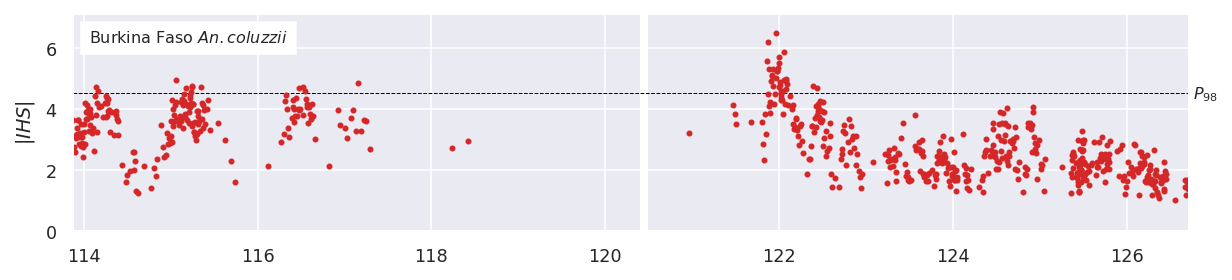

In [252]:
plot_ihs_max('bf_col', vgsc.chromosome, vgsc.chromosome_center/1e6, 
             flank=(7, 4), genetic_distance=True)

## *Gste2*

In [226]:
gste2

seqid                            3R
source                   VectorBase
type                           gene
start                      28597652
end                        28598640
score                            -1
strand                            -
phase                            -1
Name                          Gste2
biotype              protein_coding
chromosome                        3
chromosome_start           28597652
chromosome_end             28598640
chromosome_center       2.85981e+07
Name: AGAP009194, dtype: object

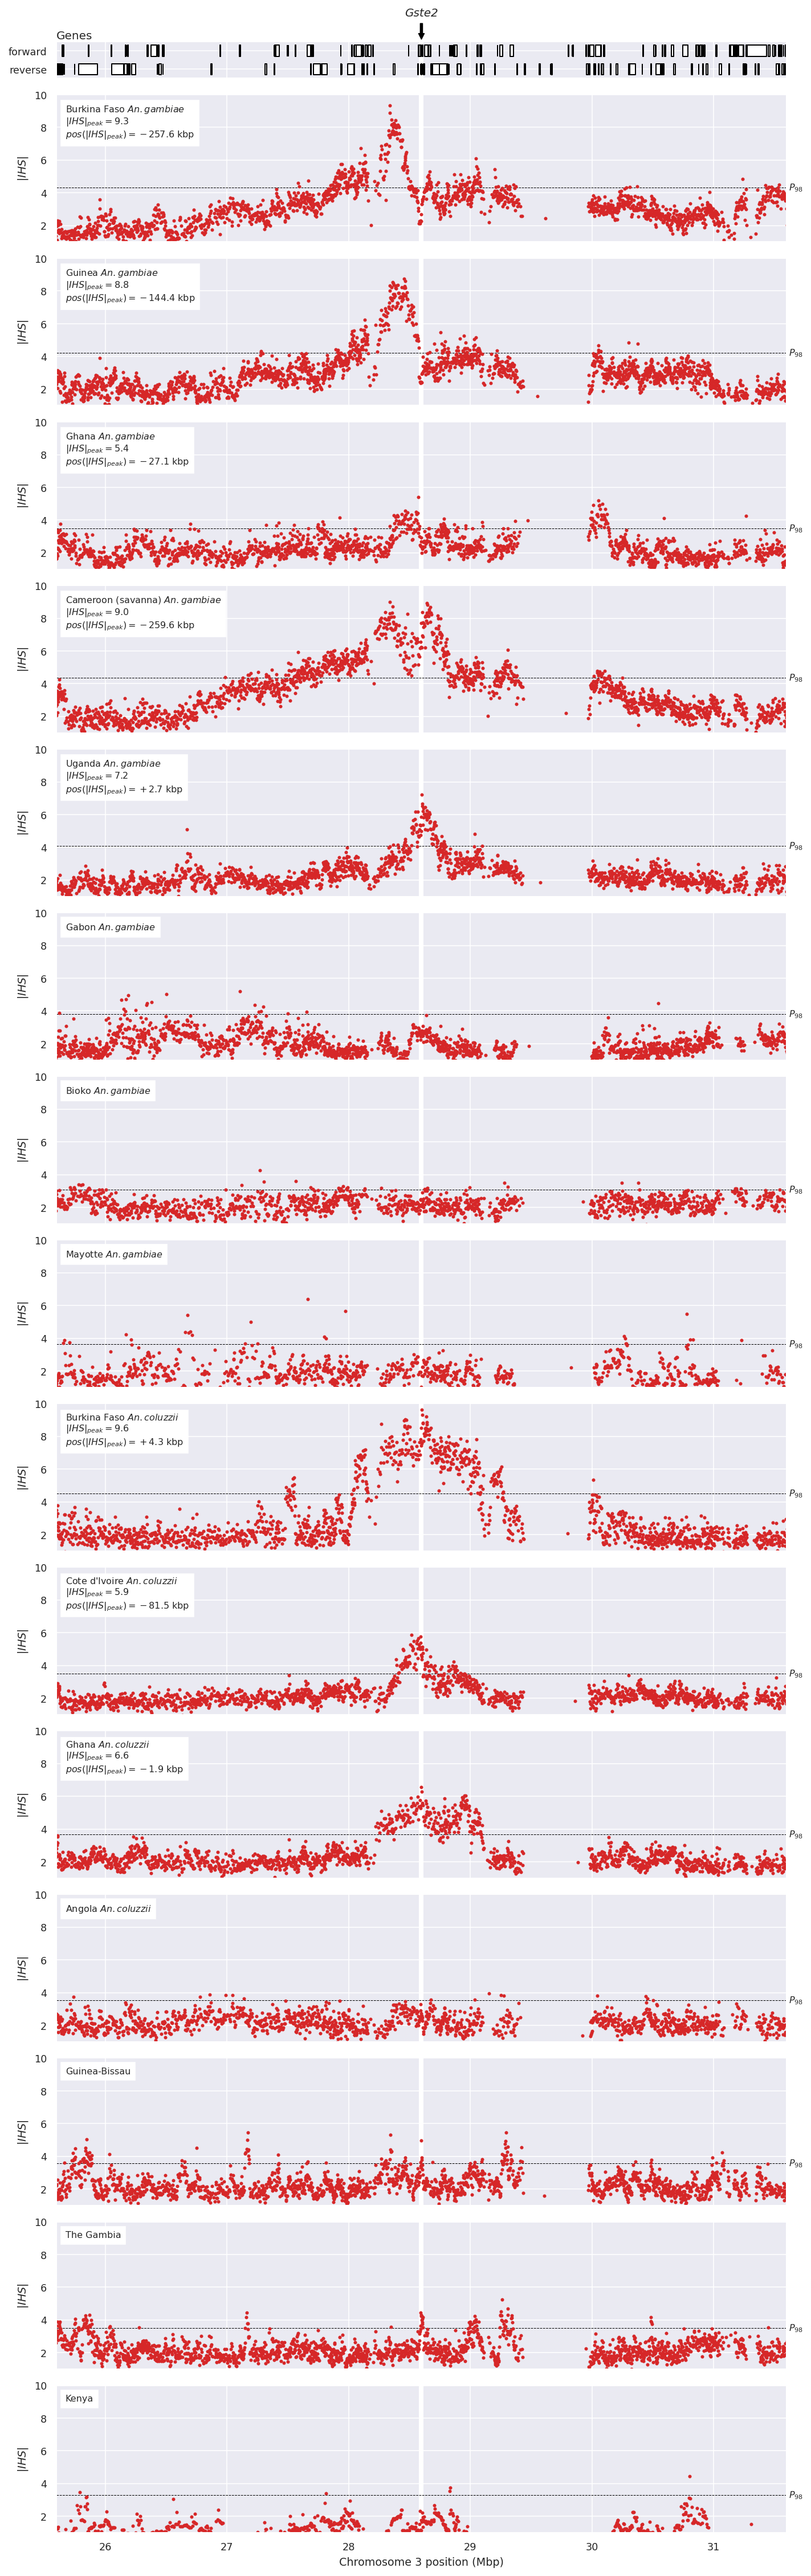

In [265]:
df_stats_gste2 = fig_locus(
    chromosome=gste2.chromosome, center=gste2.chromosome_center/1e6, 
    flank=3, label=gste2['Name'], track_height=2,
    plot_kwargs=dict(ymax=10),
    tracks=(
        (plot_ihs_max, dict(pop='bf_gam')),
        (plot_ihs_max, dict(pop='gn_gam')),
        (plot_ihs_max, dict(pop='gh_gam')),
        (plot_ihs_max, dict(pop='cm_sav_gam')),
        (plot_ihs_max, dict(pop='ug_gam')),
        (plot_ihs_max, dict(pop='ga_gam')),
        (plot_ihs_max, dict(pop='gq_gam')),
        (plot_ihs_max, dict(pop='fr_gam')),
        (plot_ihs_max, dict(pop='bf_col')),
        (plot_ihs_max, dict(pop='ci_col')),
        (plot_ihs_max, dict(pop='gh_col')),
        (plot_ihs_max, dict(pop='ao_col')),
        (plot_ihs_max, dict(pop='gw')),
        (plot_ihs_max, dict(pop='gm')),
        (plot_ihs_max, dict(pop='ke')),
    ),
)

In [266]:
gste2_peak_pops = df_stats_gste2[~df_stats_gste2.ihs_peak.isna()]['pop'].values
gste2_peak_pops

array(['bf_gam', 'gn_gam', 'gh_gam', 'cm_sav_gam', 'ug_gam', 'bf_col',
       'ci_col', 'gh_col'], dtype=object)

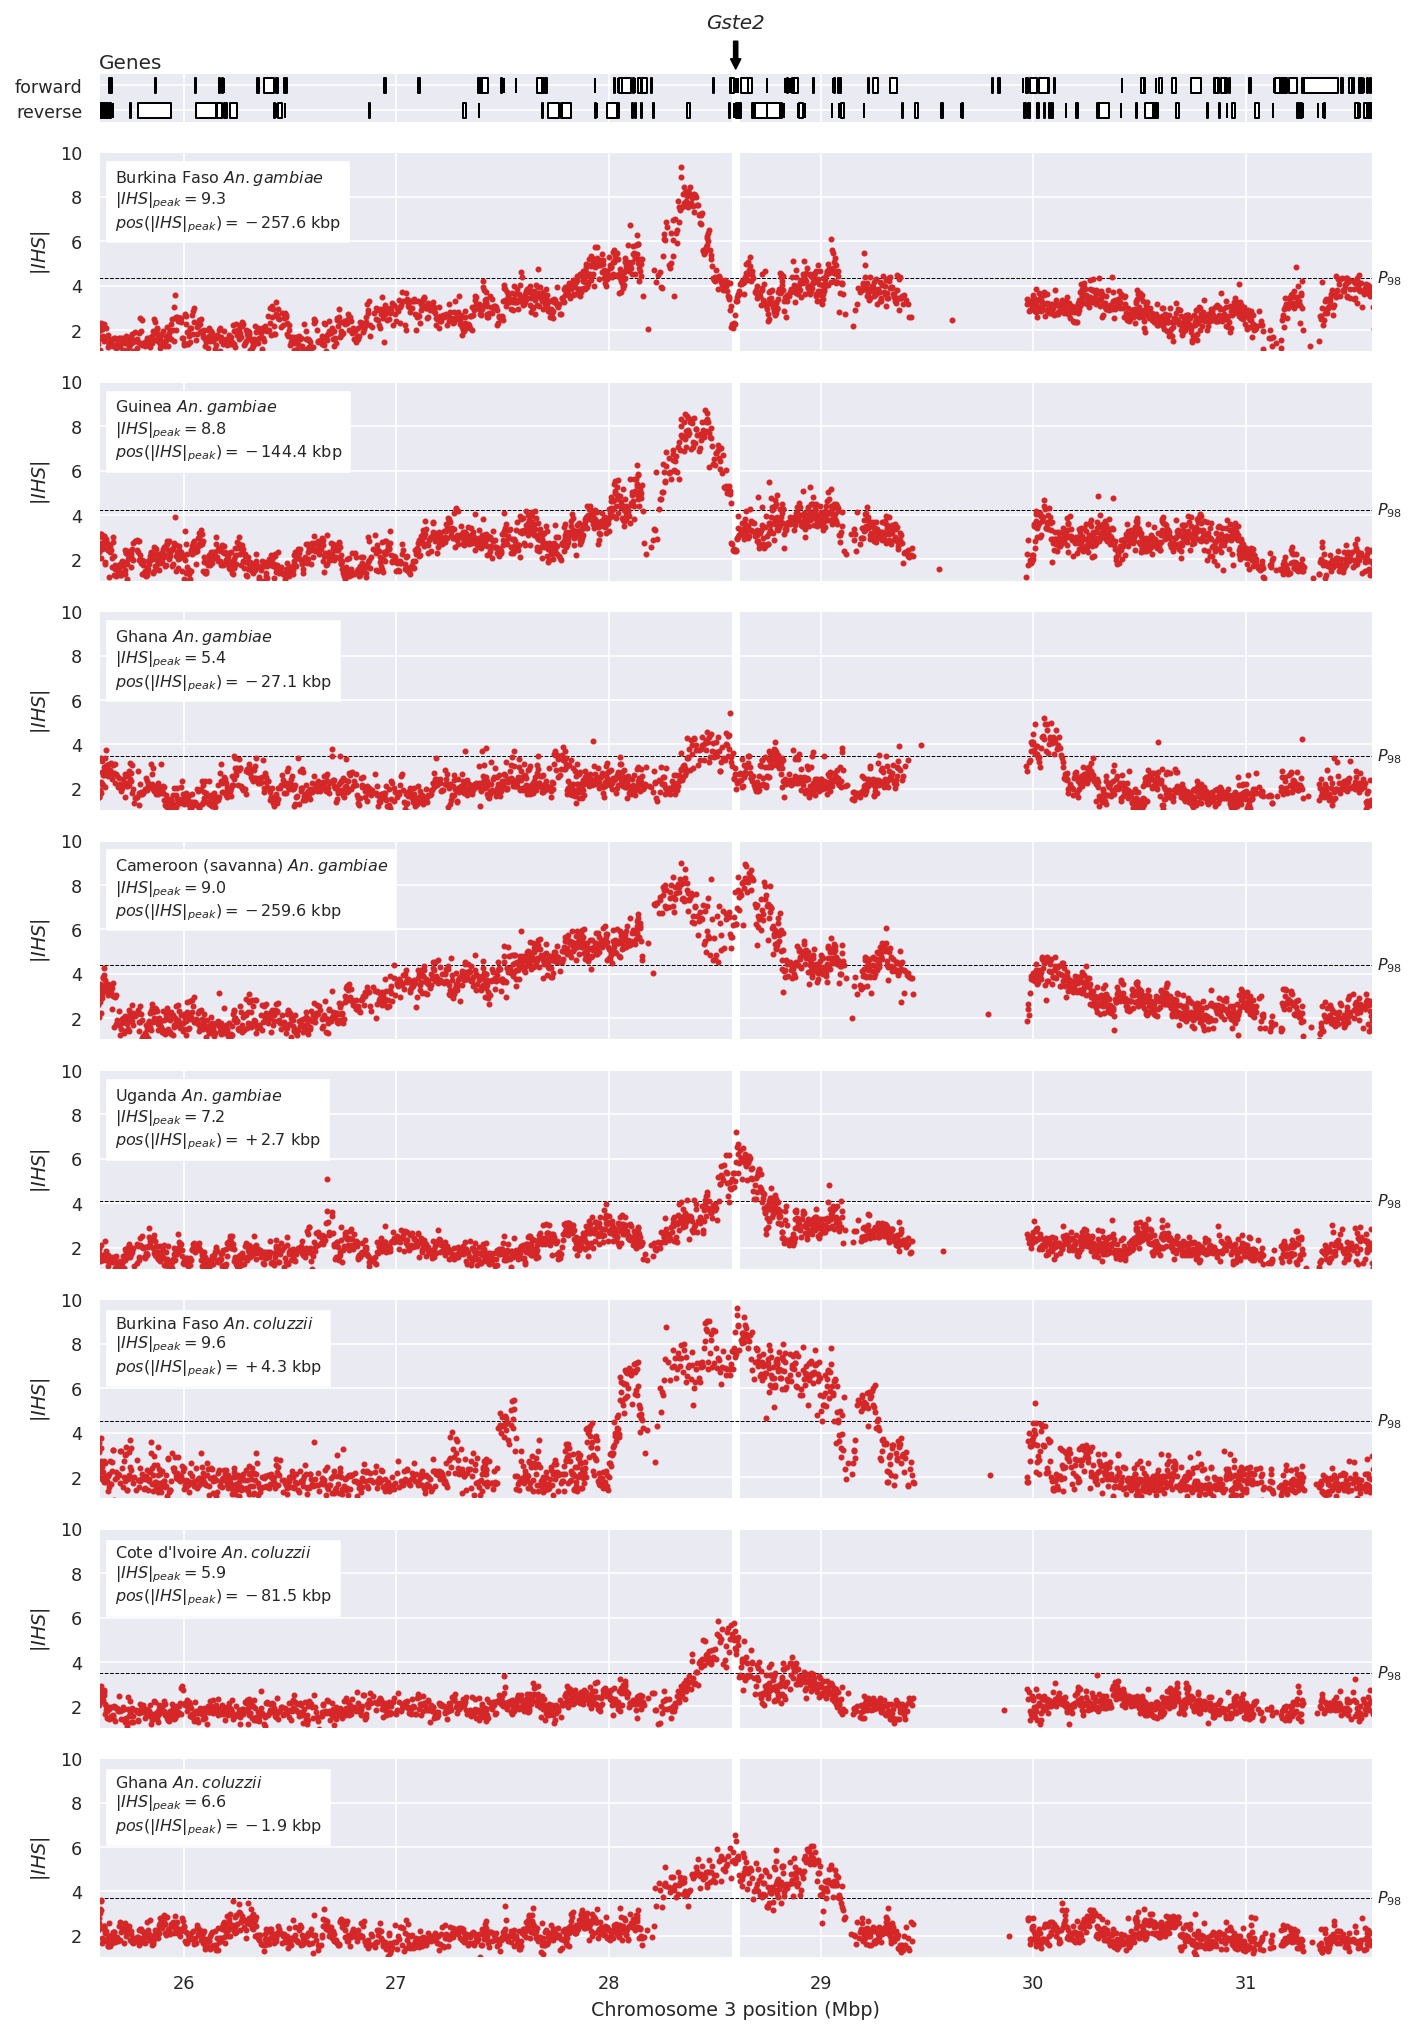

In [267]:
fig_locus(
    chromosome=gste2.chromosome, center=gste2.chromosome_center/1e6, 
    flank=3, label=gste2['Name'],
    plot_kwargs=dict(ymax=10),
    tracks=[(plot_ihs_max, dict(pop=pop)) for pop in gste2_peak_pops],
    savefig=here() / 'artwork/locus_gste2_ihs.png'
);

## *Cyp6p3*

In [168]:
cyp6p3

seqid                            2R
source                   VectorBase
type                           gene
start                      28491415
end                        28493141
score                            -1
strand                            -
phase                            -1
Name                         Cyp6p3
biotype              protein_coding
chromosome                        2
chromosome_start           28491415
chromosome_end             28493141
chromosome_center       2.84923e+07
Name: AGAP002865, dtype: object

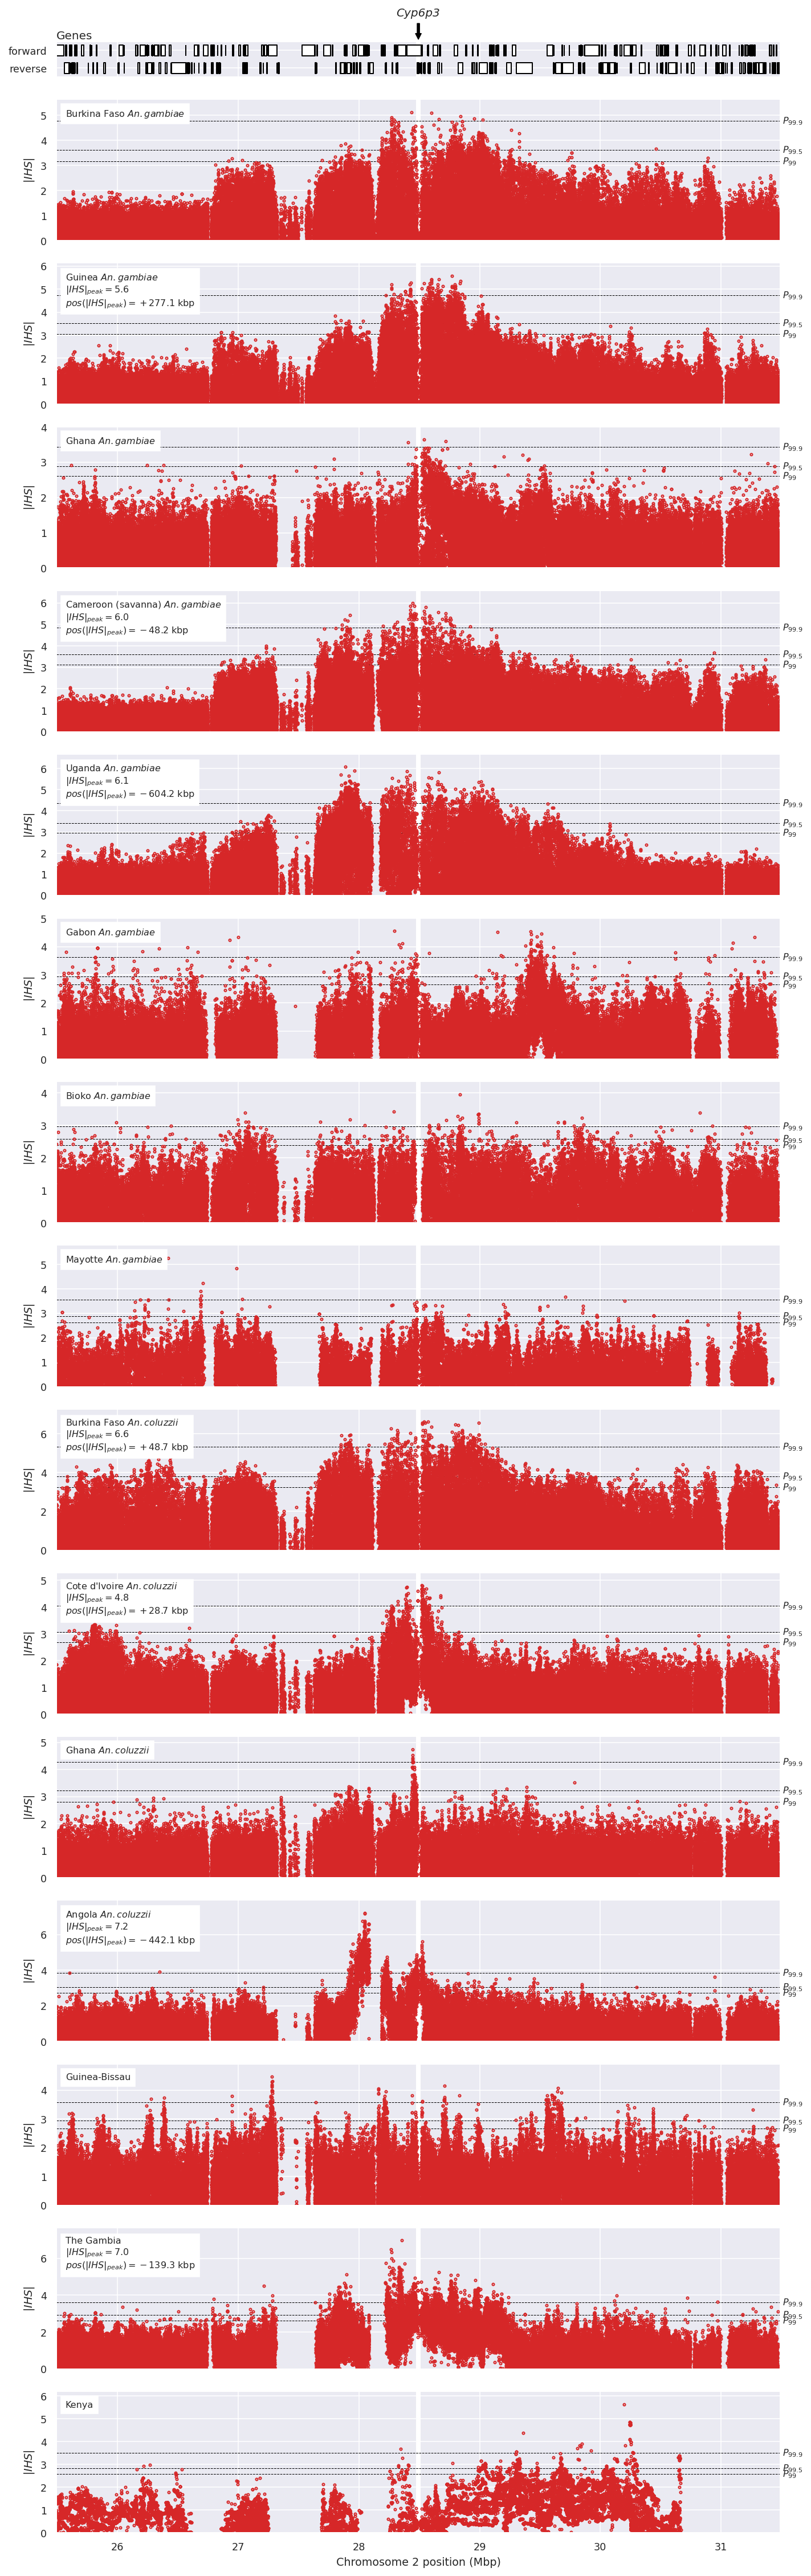

In [230]:
df_stats_cyp6p3 = fig_locus(
    chromosome=cyp6p3.chromosome, center=cyp6p3.chromosome_center/1e6, 
    flank=3, label=cyp6p3['Name'], track_height=2,
    tracks=(
        (plot_ihs, dict(pop='bf_gam')),
        (plot_ihs, dict(pop='gn_gam')),
        (plot_ihs, dict(pop='gh_gam')),
        (plot_ihs, dict(pop='cm_sav_gam')),
        (plot_ihs, dict(pop='ug_gam')),
        (plot_ihs, dict(pop='ga_gam')),
        (plot_ihs, dict(pop='gq_gam')),
        (plot_ihs, dict(pop='fr_gam')),
        (plot_ihs, dict(pop='bf_col')),
        (plot_ihs, dict(pop='ci_col')),
        (plot_ihs, dict(pop='gh_col')),
        (plot_ihs, dict(pop='ao_col')),
        (plot_ihs, dict(pop='gw')),
        (plot_ihs, dict(pop='gm')),
        (plot_ihs, dict(pop='ke')),
    ),
)

In [231]:
df_stats_cyp6p3

pop  ihs_peak  pos_ihs_peak   locus
0       bf_gam       NaN           NaN  Cyp6p3
1       gn_gam  5.579564      0.277061  Cyp6p3
2       gh_gam       NaN           NaN  Cyp6p3
3   cm_sav_gam  5.989502     -0.048180  Cyp6p3
4       ug_gam  6.075810     -0.604237  Cyp6p3
5       ga_gam       NaN           NaN  Cyp6p3
6       gq_gam       NaN           NaN  Cyp6p3
7       fr_gam       NaN           NaN  Cyp6p3
8       bf_col  6.608554      0.048713  Cyp6p3
9       ci_col  4.799893      0.028729  Cyp6p3
10      gh_col       NaN           NaN  Cyp6p3
11      ao_col  7.216196     -0.442130  Cyp6p3
12          gw       NaN           NaN  Cyp6p3
13          gm  6.965316     -0.139306  Cyp6p3
14          ke       NaN           NaN  Cyp6p3